In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

In [7]:
def seed_all(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
seed_all(2020)
DATA_PATH = './data'
BATCH_SIZE = 128
C_SIGMA, C_DELTA = tf.constant(70, dtype='float32'), tf.constant(1000, dtype='float32')
QS = [.15, .50, .85]

In [8]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
test = pd.read_csv(f'{DATA_PATH}/test.csv')
subm = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
subm['Patient'] = subm['Patient_Week'].apply(lambda x: x.split('_')[0])
subm['Weeks'] = subm['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
subm =  subm[['Patient','Weeks','Confidence','Patient_Week']]
subm = subm.merge(test.drop('Weeks', axis=1), on='Patient')
train['SPLIT'] = 'train'
test['SPLIT'] = 'val'
subm['SPLIT'] = 'test'
data = train.append([test, subm])
print('train:',  train.shape, 'unique Pats:', train.Patient.nunique(),
      '\ntest:', test.shape,  'unique Pats:', test.Patient.nunique(),
      '\nsubm:', subm.shape,  'unique Pats:', subm.Patient.nunique(),
      '\ndata',  data.shape,  'unique Pats:', data.Patient.nunique())
data.head()

train: (1535, 8) unique Pats: 176 
test: (5, 8) unique Pats: 5 
subm: (730, 10) unique Pats: 5 
data (2270, 10) unique Pats: 176


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN


In [9]:
data['min_week'] = data['Weeks']
data.loc[data.SPLIT == 'test', 'min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week,min_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0


In [10]:
data = pd.concat([data, pd.get_dummies(data.Sex), pd.get_dummies(data.SmokingStatus)], axis=1)
if True:
    base = data.loc[data.Weeks == data.min_week]
    base = base[['Patient', 'FVC']].copy()
    base.columns = ['Patient', 'min_week_FVC']
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    base = base[base.nb == 1]
    base.drop('nb', axis=1, inplace=True)
    data = data.merge(base, on='Patient', how='left')
    data['relative_week'] = data['Weeks'] - data['min_week']
    del base
    target_cols = [
        'FVC',
        'Percent',
        'min_week_FVC'
    ]
    enc_cols =  [ 
        'Female',
        'Male',
        'Currently smokes',
        'Ex-smoker',
        'Never smoked'
    ]
    if True:
        for t_col in target_cols:
            for col in enc_cols:
                col_name = f'_{col}_{t_col}_'
                data[f'enc{col_name}mean'] = data.groupby(col)[t_col].transform('mean')
                data[f'enc{col_name}std'] = data.groupby(col)[t_col].transform('std')
        data['TC'] = 0
        data.loc[data['Weeks'] == 0, 'TC'] = 1
print(data.shape)
print(data.columns)
data.head()

(2270, 49)
Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'SPLIT', 'Confidence', 'Patient_Week', 'min_week', 'Female', 'Male',
       'Currently smokes', 'Ex-smoker', 'Never smoked', 'min_week_FVC',
       'relative_week', 'enc_Female_FVC_mean', 'enc_Female_FVC_std',
       'enc_Male_FVC_mean', 'enc_Male_FVC_std',
       'enc_Currently smokes_FVC_mean', 'enc_Currently smokes_FVC_std',
       'enc_Ex-smoker_FVC_mean', 'enc_Ex-smoker_FVC_std',
       'enc_Never smoked_FVC_mean', 'enc_Never smoked_FVC_std',
       'enc_Female_Percent_mean', 'enc_Female_Percent_std',
       'enc_Male_Percent_mean', 'enc_Male_Percent_std',
       'enc_Currently smokes_Percent_mean', 'enc_Currently smokes_Percent_std',
       'enc_Ex-smoker_Percent_mean', 'enc_Ex-smoker_Percent_std',
       'enc_Never smoked_Percent_mean', 'enc_Never smoked_Percent_std',
       'enc_Female_min_week_FVC_mean', 'enc_Female_min_week_FVC_std',
       'enc_Male_min_week_FVC_mean', 'enc_Male_min

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week,...,enc_Female_min_week_FVC_std,enc_Male_min_week_FVC_mean,enc_Male_min_week_FVC_std,enc_Currently smokes_min_week_FVC_mean,enc_Currently smokes_min_week_FVC_std,enc_Ex-smoker_min_week_FVC_mean,enc_Ex-smoker_min_week_FVC_std,enc_Never smoked_min_week_FVC_mean,enc_Never smoked_min_week_FVC_std,TC
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,668.983625,2924.511556,668.983625,2769.366088,737.899096,2837.199629,726.529482,2856.481765,725.094491,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,668.983625,2924.511556,668.983625,2769.366088,737.899096,2837.199629,726.529482,2856.481765,725.094491,0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,668.983625,2924.511556,668.983625,2769.366088,737.899096,2837.199629,726.529482,2856.481765,725.094491,0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,668.983625,2924.511556,668.983625,2769.366088,737.899096,2837.199629,726.529482,2856.481765,725.094491,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,668.983625,2924.511556,668.983625,2769.366088,737.899096,2837.199629,726.529482,2856.481765,725.094491,0


In [11]:
feat_cols = [
    'Female', 'Male',
    'Currently smokes', 'Ex-smoker', 'Never smoked',
    'TC'
]
scale_cols = [
    'Percent', 
    'Age', 
    'relative_week', 
    'min_week_FVC'
]
scale_cols.extend([x for x in data.columns if 'FVC_mean' in x])
scaler = MinMaxScaler()
data[scale_cols] = scaler.fit_transform(data[scale_cols])
feat_cols.extend(scale_cols)
print('all data columns:', data.columns)

all data columns: Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'SPLIT', 'Confidence', 'Patient_Week', 'min_week', 'Female', 'Male',
       'Currently smokes', 'Ex-smoker', 'Never smoked', 'min_week_FVC',
       'relative_week', 'enc_Female_FVC_mean', 'enc_Female_FVC_std',
       'enc_Male_FVC_mean', 'enc_Male_FVC_std',
       'enc_Currently smokes_FVC_mean', 'enc_Currently smokes_FVC_std',
       'enc_Ex-smoker_FVC_mean', 'enc_Ex-smoker_FVC_std',
       'enc_Never smoked_FVC_mean', 'enc_Never smoked_FVC_std',
       'enc_Female_Percent_mean', 'enc_Female_Percent_std',
       'enc_Male_Percent_mean', 'enc_Male_Percent_std',
       'enc_Currently smokes_Percent_mean', 'enc_Currently smokes_Percent_std',
       'enc_Ex-smoker_Percent_mean', 'enc_Ex-smoker_Percent_std',
       'enc_Never smoked_Percent_mean', 'enc_Never smoked_Percent_std',
       'enc_Female_min_week_FVC_mean', 'enc_Female_min_week_FVC_std',
       'enc_Male_min_week_FVC_mean', 'enc_M

In [12]:
train = data.loc[data.SPLIT == 'train']
test = data.loc[data.SPLIT == 'val']
subm = data.loc[data.SPLIT == 'test']
del data

In [13]:
def metric(y_true, y_pred, pred_std):
    clip_std = np.clip(pred_std, 70, 9e9)  
    delta = np.clip(np.abs(y_true - y_pred), 0 , 1000)  
    return np.mean(-1 * (np.sqrt(2) * delta / clip_std) - np.log(np.sqrt(2) * clip_std))
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    sigma_clip = tf.maximum(sigma, C_SIGMA)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C_DELTA)
    sq2 = tf.sqrt(tf.dtypes.cast(2, dtype=tf.float32))
    metric = sq2 * (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)
def qloss(y_true, y_pred):
    q = tf.constant(np.array([QS]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q - 1) * e)
    return K.mean(v)
def mloss(lmbd):
    def loss(y_true, y_pred):
        return lmbd * qloss(y_true, y_pred) + (1 - lmbd) * score(y_true, y_pred)
    return loss
def get_model(input_shape, units=128, prob=.4, lmbd=.8):
    inputs = L.Input(shape=(input_shape, ))
    x = L.Dense(units, activation='elu')(inputs)
    x = L.Dropout(prob)(x)
    x = L.Dense(units, activation='elu')(x)
    x = L.Dropout(prob)(x)
    preds = L.Dense(3, activation='linear')(x)
    model = M.Model(inputs, preds)
    model.compile(
        loss=mloss(lmbd),
        optimizer=Adam(lr=0.01), 
        metrics=[score]
    )
    return model

In [14]:
%%time
N_FOLDS = 5
EPOCHS = 1000
print('feature columns:', feat_cols)
y_train = train['FVC'].values
X_train = train[feat_cols].values
y_val = test['FVC'].values
X_val = test[feat_cols].values
X_subm = subm[feat_cols].values
input_shape = X_train.shape[1]
preds_subm = np.zeros((X_subm.shape[0], 3))
preds_val = np.zeros((X_val.shape[0], 3))
preds = np.zeros((X_train.shape[0], 3))
kfold = KFold(n_splits=N_FOLDS)
for num_fold, (train_idxs, val_idxs) in enumerate(kfold.split(X_train)):
    print('=' * 10, f'fold: {num_fold}', '=' * 10)
    earlystopper = EarlyStopping(
        monitor='val_score', 
        patience=80, 
        verbose=0,
        mode='min'
        )
    lrreducer = ReduceLROnPlateau(
        monitor='val_score',
        factor=.1,
        patience=40,
        verbose=0,
        min_lr=1e-5,
        mode='min'
    )
    model = get_model(input_shape, units=256, prob=0, lmbd=.8)
    model.fit(
        X_train[train_idxs], 
        y_train[train_idxs], 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        validation_data=(X_train[val_idxs], y_train[val_idxs]), 
        callbacks=[earlystopper, lrreducer],
        verbose=0
    )
    print(
        'train eval | loss, score:', 
        model.evaluate(X_train[train_idxs], y_train[train_idxs], verbose=0, batch_size=BATCH_SIZE)
    )
    print(
        'val eval | loss, score:', 
        model.evaluate(X_train[val_idxs], y_train[val_idxs], verbose=0, batch_size=BATCH_SIZE)
    )
    preds[val_idxs] = model.predict(X_train[val_idxs], batch_size=BATCH_SIZE, verbose=0)
    preds_subm += model.predict(X_subm, batch_size=BATCH_SIZE, verbose=0) / N_FOLDS
    preds_val += model.predict(X_val, batch_size=BATCH_SIZE, verbose=0) / N_FOLDS
print('metric train:', metric(y_train, preds[:, 1], preds[:,2] - preds[:, 0]))
print('metric val:', metric(y_val, preds_val[:, 1], preds_val[:,2] - preds_val[:, 0]))

feature columns: ['Female', 'Male', 'Currently smokes', 'Ex-smoker', 'Never smoked', 'TC', 'Percent', 'Age', 'relative_week', 'min_week_FVC', 'enc_Female_FVC_mean', 'enc_Male_FVC_mean', 'enc_Currently smokes_FVC_mean', 'enc_Ex-smoker_FVC_mean', 'enc_Never smoked_FVC_mean', 'enc_Female_min_week_FVC_mean', 'enc_Male_min_week_FVC_mean', 'enc_Currently smokes_min_week_FVC_mean', 'enc_Ex-smoker_min_week_FVC_mean', 'enc_Never smoked_min_week_FVC_mean']
========== fold: 0 ==========
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
train eval | loss, score: [37.31059603116412, 6.859674]
val eval | loss, score: [42.34870099244755, 7.025984]
========== fold: 1 ==========
train eval | loss, score: [37.79995032941091, 6.8804827]
val eval | loss, score: [41.017510827278855, 6.9516597]
========== fold: 2 ==========
train eval | loss, score

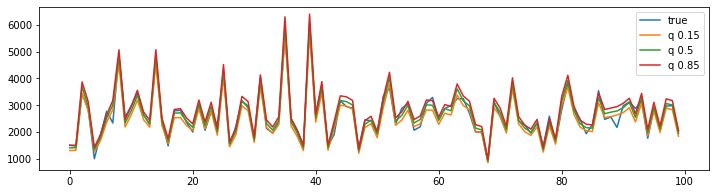

In [15]:
idxs = np.random.randint(0, y_train.shape[0], 100)
plt.figure(figsize=(12, 3))
plt.plot(y_train[idxs], label='true')
plt.plot(preds[idxs, 0], label=f'q {QS[0]}')
plt.plot(preds[idxs, 1], label=f'q {QS[1]}')
plt.plot(preds[idxs, 2], label=f'q {QS[2]}')
plt.legend(loc='best')
plt.show()

In [16]:
subm['FVC'] = preds_subm[:, 1]
subm['Confidence'] = preds_subm[:, 2] - preds_subm[:, 0]
subm[['Patient_Week','FVC','Confidence']].to_csv('submission.csv', index=False)
subm[['Patient_Week','FVC','Confidence']].describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2635.132330,337.924248,1912.581360,2560.455444,2693.727264,2830.065720,3243.332153
Confidence,730.0,300.553999,35.435675,225.359436,294.052658,306.820007,320.097321,359.053223
